# Analysis - Congressional Fundraising and Votes

### Set-up

In [2]:
#import dependencies
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sqlite3 as lite
import sys

plt.style.use('fivethirtyeight')
sns.set()
%matplotlib inline
#import dataset
data = pd.read_csv('new data.csv')
data['vote'] = [0 for _ in range(len(data))]
data['party'] = [0 for _ in range(len(data))]
#remove candidates for which we have no fundrasing data
data = data[data['amount'] != '0']
#prepare for cleaning
a = np.array(data.as_matrix())
data[1:10]

ddata = pd.read_csv('indivs16a.csv')
ddata[1:10]



FileNotFoundError: File b'indivs16a.csv' does not exist

### Cleaning

#### Clean Fundraising Data

In [2]:
#trim candidate names
for i in range(len(a)):
    t = a[i][0].split(' (')
    a[i][0] = t[0]
    if len(t) > 1:
        a[i][3] = t[1].split(')')[0]

#split large dataset into small arrays by district
b = np.split(a, (a.transpose()[0] == 'Candidate').nonzero()[0] - 1)
#for i in range(len(b)):
#    b[i] = b[i][1:]
    #todo: add votes header
us_state_abbrev = { 'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
                   'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
                   'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
                   'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
                   'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI',
                   'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT',
                   'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
                   'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND',
                   'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
                   'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
                   'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
                   'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY', }

#### Clean Voting Data

In [3]:
#read votes data
voting = pd.read_csv('voting2.csv')
v = voting.values
to_del = []
for i in  range(len(v)):
    v[i][0] = v[i][0].split(' (')
    if '%' in v[i][0][1]:
        t = v[i][0][1].split(') ')[1]
        vote = t[:t.index('%')]
        try:
            vote = float(vote)
            if vote < 5:
                to_del.append(i)
            v[i][0][1] = vote
        except ValueError:
            #delete rows for which we don't have vote data
            to_del.append(i)
    else:
        to_del.append(i)
v = np.delete(v, to_del, 0)
for i in range(len(a)):
    if a[i][3] == 0:
        j = 1
    elif a[i][3] == 'R':
        a[i][3] = 0.0
    elif a[i][3] == 'D':
        a[i][3] = 1.0
    else:
        a[i][3] = 0.5

#### Match Vote % to Candidates



In [4]:
#todo: make more efficient
for k in range(len(v)):
    for i in range(len(b)):
        if v[k][0][0] in b[i][:,0]:
            for j in range(len(b[i])):
                if v[k][0][0] in b[i][j]:
                    b[i][j][2] = v[k][0][1]

#### Example Chunk

In [5]:
df = pd.DataFrame(b[63])
df
#todo: convert headers

,0,1,2,3
0,California District 42,NaN,0,0
1,Candidate,Candidate Raised,0,0
2,Ken Calvert,1443899,58.8,0
3,Tim Sheridan,138396,41.2,1


### Calculations

#### Calculate % Raised for Each Candiate in Chunk



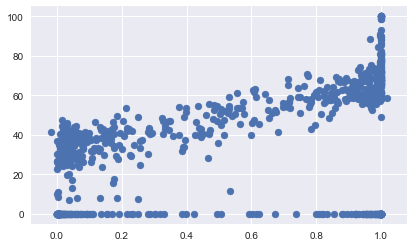

In [6]:
def calc(x):
    total = sum(x[2:][:,1].astype(int))
    names = x[2:][:,0].astype(str)
    spends = [i / total for i in x[2:][:,1].astype(int)]
    votes = x[2:][:,2].astype(float)
    #return list of lists: [% raised, % votes]
    i = [list(a) for a in zip(spends, votes, x[2:][:,3], names)]
    for j in i:
        j.append(total)
        #print(us_state_abbrev[x[0][0].split(' District ')[0]] + x[0][0].split(' District ')[1], j)
    return i

d = np.array([[0,0, 0, 0, 0]])
for i in range(1, len(b)):
    d = np.concatenate((d, calc(b[i])), axis = 0)
x, y, = d[:,0], d[:,1]
plt.scatter(x, y)

#### Clean Data

In [7]:
#remove rows without voting data
d = np.delete(d, 3, 1).astype(float)

d = d[d[:,1] != 0]

#remove rows with highly imbalanced funding
d = d[d[:,0] < .999]
d = d[d[:,0] > .001]
x, y, p, z = d[:,0], d[:,1], d[:,2], d[:,3]

### Graphing

#### Basic Trend

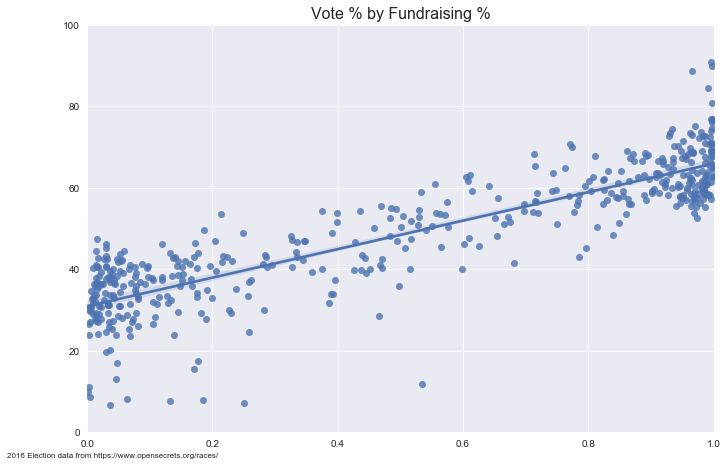

In [8]:
plt.figure(figsize=(10, 7.5))

#plot linear regression
plt.ylim(0, 100)
plt.xlim(0, 1)
sns.regplot(x, y, scatter = True, robust = False, n_boot = 100)

#add text
plt.title('Vote % by Fundraising %', fontsize=16)
plt.annotate('2016 Election data from https://www.opensecrets.org/races/', (0,0), (-80,-20), fontsize=8, 
             xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

#### Points shaded by amount raised

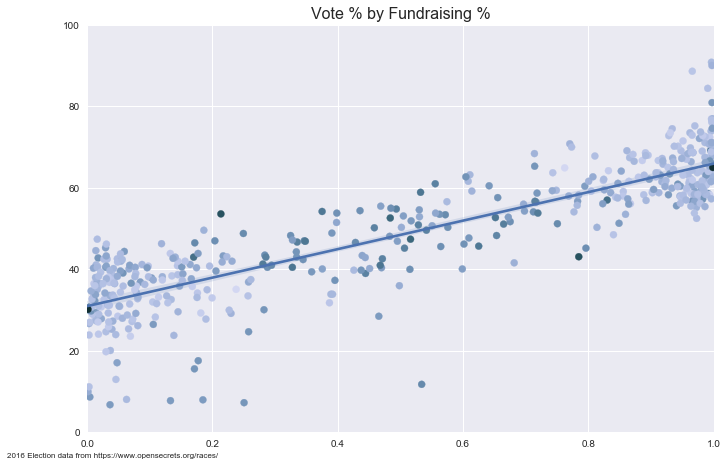

In [9]:
plt.figure(figsize=(10, 7.5))

#plot linear regression
plt.ylim(0, 100)
plt.xlim(0, 1)
sns.regplot(x, y, scatter = False, robust = False, n_boot = 100)

#color points by amount raised (darker = more)
#scale z to 1
z1 = z / max(z)
z2 = z1 ** .5
cmap = sns.cubehelix_palette(start = 2.4, rot = .2, as_cmap=True)
plt.scatter(x, y, c=z2, s=50, cmap=cmap)

#add text
plt.title('Vote % by Fundraising %', fontsize=16)
plt.annotate('2016 Election data from https://www.opensecrets.org/races/', (0,0), (-80,-20), fontsize=8, 
             xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

#### Points colored by party

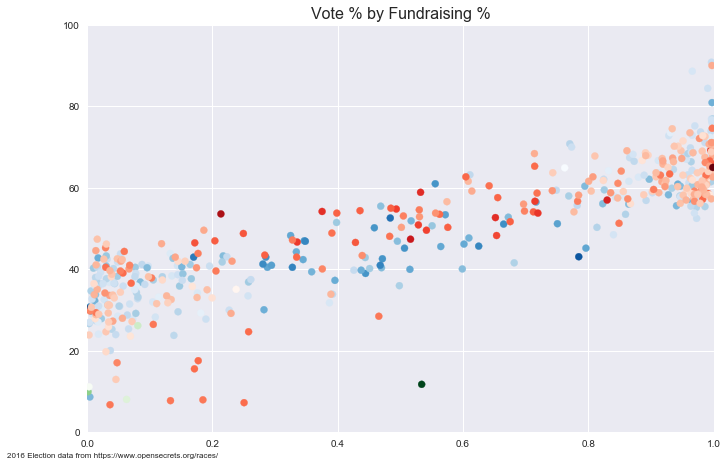

In [10]:
plt.figure(figsize=(10, 7.5))
#plt.annotate(fit[0][1], (0,0), (-80,-20), fontsize=8)
#plot linear regression
plt.ylim(0, 100)
plt.xlim(0, 1)

#color points by amount raised (darker = more)
#scale z to 1
z1 = z / max(z)
#curve z to allow for more useful distribution
z2 = z1 ** .33

plt.scatter(x[p == 1.0], y[p == 1.0], c=z2[p == 1.0], s=50, cmap='Blues')
plt.scatter(x[p == 0.0], y[p == 0.0], c=z2[p == 0.0], s=50, cmap='Reds')
plt.scatter(x[p == 0.5], y[p == 0.5], c=z2[p == 0.5], s=50, cmap='Greens')
#plt.Axes.set_xlabel('xlabel')
#plt.Axes.set_ylabel('ylabel')
#add text
plt.title('Vote % by Fundraising %', fontsize=16)
plt.annotate('2016 Election data from https://www.opensecrets.org/races/', (0,0), (-80,-20), fontsize=8, 
             xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

In [11]:
#fucntion to output difference between two polyfits
def diff(d1, d2):
    f1 = np.polyfit(d1[0], d1[1], 1)
    f2 = np.polyfit(d2[0], d2[1], 1)
    return (abs(f1 - f2) / (sum(f1, f2) / 2)), f1, f2

As you can see, the data is pretty consistent between D and R (the lines overlap so much you can't differentiate), however, there is not enough data for third-party candidates

% difference between D and R regression: 
[ 0.07601229  0.29589294]


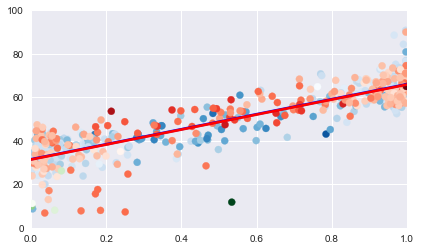

In [12]:
sns.regplot(x[p == 1.0], y[p == 1.0], scatter = False, robust = False, n_boot = 100, ci = None, color='b')
sns.regplot(x[p == 0.0], y[p == 0.0], scatter = False, robust = False, n_boot = 100, ci = None, color='r')
#sns.regplot(x[p == 0.5], y[p == 0.5], scatter = False, robust = False, n_boot = 100, ci = None, color='g')
plt.ylim(0, 100)
plt.xlim(0, 1)
plt.scatter(x[p == 1.0], y[p == 1.0], c=z2[p == 1.0], s=50, cmap='Blues')
plt.scatter(x[p == 0.0], y[p == 0.0], c=z2[p == 0.0], s=50, cmap='Reds')
plt.scatter(x[p == 0.5], y[p == 0.5], c=z2[p == 0.5], s=50, cmap='Greens')
print('% difference between D and R regression: ')
print(diff([x[p == 1.0], y[p == 1.0]], [x[p == 0.0], y[p == 0.0]])[0] * 100)

### Misc Analysis

In [13]:
s = x[y > 50]
print(s.mean())
print(x.mean())
low, high = 30, 70
x_trim = [x[i] for i in range(len(x)) if low < y[i] < high]
y_trim = [y[i] for i in range(len(y)) if low < y[i] < high]
d, f_trim, f_full = diff([x_trim, y_trim], [x, y])
d

0.862942109515
0.505074873992


array([ 0.1429432 ,  0.09304409])

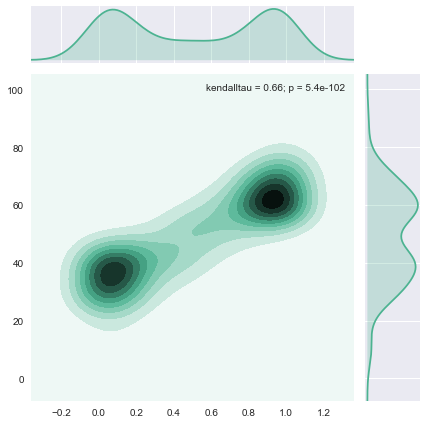

In [14]:
from scipy.stats import kendalltau
sns.jointplot(x, y, kind="kde", stat_func=kendalltau, color="#4CB391")